## ML Model Building Pipeline: Part 4: ML Model Build

This is fourth notebook in a series of notebooks to build the house median price prediction models.

## Model building

In the following cells, we will finally build our machine learning model, utilising the engineered data and the pre-selected features. 


### Setting the seed

It is important to note, that we are engineering variables and pre-processing data with the idea of deploying the model. Therefore, from now on, for each step that includes some element of randomness, it is extremely important that we **set the seed**. This way, we can obtain reproducibility between our research and our development code.


Let's go ahead and load the dataset.

### Overall Structure

- Load libraries
- Import data and features list
- Filter data to the needed features
- Fit a lasso regression and evaluate train, test performance (mse, rmse, r2)
- Plot actuals vs predictions and distributions of residuals

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# to build the model
from sklearn.linear_model import Lasso

# to evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
# load the train and test set with the engineered variables

X_train = pd.read_csv('data/xtrain.csv')
X_test = pd.read_csv('data/xtest.csv')

X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,931,0.000000,0.75,0.461171,0.377048,1.0,1.0,0.333333,1.000000,1.0,0.0,0.0,0.863636,0.4,1.0,0.75,0.6,0.777778,0.50,0.014706,0.049180,0.0,0.0,1.0,1.0,0.000000,0.00000,0.666667,1.0,1.0,0.75,0.75,0.75,1.000000,0.002835,0.666667,0.0,0.673479,0.239935,1.0,1.00,1.0,1.0,0.559760,0.0,0.0,0.523250,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.416667,1.0,0.000000,0.2,0.8,0.018692,1.000000,0.75,0.430183,0.666667,1.0,1.0,0.116686,0.032907,0.0,0.000000,0.0,0.0,0.0,0.75,1.0,0.0,0.545455,0.75,0.666667,0.75,12.211060,0.0,0.0,0.0
1,657,0.000000,0.75,0.456066,0.399443,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.363636,0.4,1.0,0.75,0.6,0.444444,0.75,0.360294,0.049180,0.0,0.0,0.6,0.6,0.666667,0.03375,0.666667,1.0,0.5,0.50,0.75,0.25,0.666667,0.142807,0.666667,0.0,0.114724,0.172340,1.0,1.00,1.0,1.0,0.434539,0.0,0.0,0.406196,0.333333,0.0,0.333333,0.5,0.375,0.333333,0.666667,0.250000,1.0,0.000000,0.2,0.8,0.457944,0.666667,0.25,0.220028,0.666667,1.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.50,1.0,0.0,0.636364,0.50,0.666667,0.75,11.887931,0.0,0.0,0.0
2,46,0.588235,0.75,0.394699,0.347082,1.0,1.0,0.000000,0.333333,1.0,0.0,0.0,0.954545,0.4,1.0,1.00,0.6,0.888889,0.50,0.036765,0.098361,1.0,0.0,0.3,0.2,0.666667,0.25750,1.000000,1.0,1.0,1.00,0.75,0.25,1.000000,0.080794,0.666667,0.0,0.601951,0.286743,1.0,1.00,1.0,1.0,0.627205,0.0,0.0,0.586296,0.333333,0.0,0.666667,0.0,0.250,0.333333,1.000000,0.333333,1.0,0.333333,0.8,0.8,0.046729,0.666667,0.50,0.406206,0.666667,1.0,1.0,0.228705,0.149909,0.0,0.000000,0.0,0.0,0.0,0.75,1.0,0.0,0.090909,1.00,0.666667,0.75,12.675764,0.0,0.0,0.0
3,1349,0.000000,0.75,0.388581,0.493677,1.0,1.0,0.666667,0.666667,1.0,0.0,0.0,0.454545,0.4,1.0,0.75,0.6,0.666667,0.50,0.066176,0.163934,0.0,0.0,1.0,1.0,0.000000,0.00000,0.666667,1.0,1.0,0.75,0.75,1.00,1.000000,0.255670,0.666667,0.0,0.018114,0.242553,1.0,1.00,1.0,1.0,0.566920,0.0,0.0,0.529943,0.333333,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.250000,1.0,0.333333,0.4,0.8,0.084112,0.666667,0.50,0.362482,0.666667,1.0,1.0,0.469078,0.045704,0.0,0.000000,0.0,0.0,0.0,0.75,1.0,0.0,0.636364,0.25,0.666667,0.75,12.278393,1.0,0.0,0.0
4,56,0.000000,0.75,0.577658,0.402702,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.363636,0.4,1.0,0.75,0.6,0.555556,0.50,0.323529,0.737705,0.0,0.0,0.6,0.7,0.666667,0.17000,0.333333,1.0,0.5,0.50,0.75,0.25,0.333333,0.086818,0.666667,0.0,0.434278,0.233224,1.0,0.75,1.0,1.0,0.549026,0.0,0.0,0.513216,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.333333,0.416667,1.0,0.333333,0.8,0.8,0.411215,0.666667,0.50,0.406206,0.666667,1.0,1.0,0.000000,0.000000,0.0,0.801181,0.0,0.0,0.0,0.75,1.0,0.0,0.545455,0.50,0.666667,0.75,12.103486,0.0,0.0,0.0


In [3]:
# capture the target (remember that is log transformed)

y_train = X_train['SalePrice']
y_test = X_test['SalePrice']

In [5]:
# load the pre-selected features
# ==============================

# we selected the features in the previous notebook (step 3)

features = pd.read_csv('data/selected_features.csv')
features = features['0'].to_list() 

# We will add one additional feature to the ones we selected in the
# previous notebook: LotFrontage

features = features + ['LotFrontage'] 

# display final feature set
features

['MSSubClass',
 'MSZoning',
 'Neighborhood',
 'OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'RoofStyle',
 'MasVnrType',
 'BsmtQual',
 'BsmtExposure',
 'HeatingQC',
 'CentralAir',
 '1stFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'KitchenQual',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'PavedDrive',
 'LotFrontage']

In [6]:
# reduce the train and test set to the selected features

X_train = X_train[features]
X_test = X_test[features]

### Regularised linear regression: Lasso

Remember to set the seed.

In [7]:
# set up the model
# remember to set the random_state / seed

lin_model = Lasso(alpha=0.005, random_state=0)

# train the model

lin_model.fit(X_train, y_train)

Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False)

In [8]:
# evaluate the model:
# ====================

# remember that we log transformed the output (SalePrice)
# in our feature engineering notebook (step 2).

# In order to get the true performance of the Lasso
# we need to transform both the target and the predictions
# back to the original house prices values.

# We will evaluate performance using the mean squared error and
# the root of the mean squared error and r2

# make predictions for train set
pred = lin_model.predict(X_train)

# determine mse and rmse
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    sqrt(mean_squared_error(np.exp(y_train), np.exp(pred))))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = lin_model.predict(X_test)

# determine mse and rmse
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    sqrt(mean_squared_error(np.exp(y_test), np.exp(pred))))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

train mse: 1087435415
train rmse: 32976
train r2: 0.8258384535431156

test mse: 1405259552
test rmse: 37486
test r2: 0.7955128088451104

Average house price:  163000


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

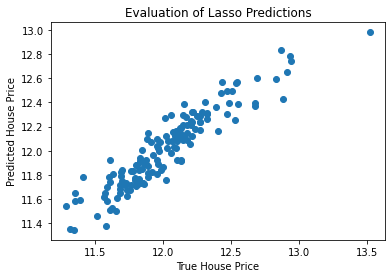

In [9]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, lin_model.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')

We can see that our model is doing a pretty good job at estimating house prices.

<AxesSubplot:>

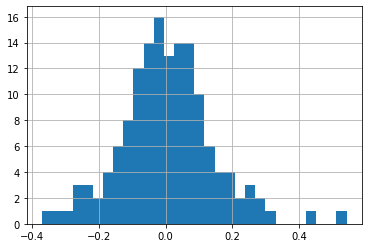

In [10]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_test - lin_model.predict(X_test)
errors.hist(bins=30)

The distribution of the errors follows quite closely a gaussian distribution. That suggests that our model is doing a good job as well.

### Feature importance

Text(0.5, 1.0, 'Feature Importance')

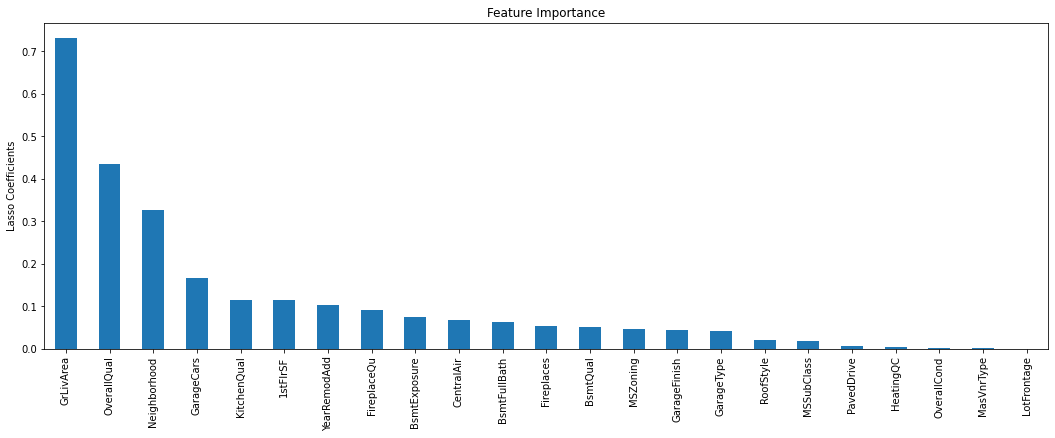

In [11]:
# Finally, just for fun, let's look at the feature importance

importance = pd.Series(np.abs(lin_model.coef_.ravel()))
importance.index = features
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')

And that is all! Now we have our entire pipeline ready for deployment. 